In [0]:
# Load the necessary packages
import json  
import re
from collections import Counter
import time
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize  
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from textblob import TextBlob
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error as MSE

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

SEED = 42

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# Set up shared drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load datasets: 3 CSV files of video data and 3 json files of category data 
ca_path = '/content/drive/My Drive/Data Mining Project/data/CAvideos.csv'
ca = pd.read_csv(ca_path)

gb_path = '/content/drive/My Drive/Data Mining Project/data/GBvideos.csv'
gb = pd.read_csv(gb_path)

us_path = '/content/drive/My Drive/Data Mining Project/data/USvideos.csv'
us = pd.read_csv(us_path)

ca_cat_path = '/content/drive/My Drive/Data Mining Project/data/CA_category_id.json'
ca_cat = pd.read_json(ca_cat_path)

gb_cat_path = '/content/drive/My Drive/Data Mining Project/data/GB_category_id.json'
gb_cat = pd.read_json(gb_cat_path)

us_cat_path = '/content/drive/My Drive/Data Mining Project/data/US_category_id.json'
us_cat = pd.read_json(us_cat_path)


In [0]:
# Process category data so that they contain information we are most interested in 
ca_cat_id = ca_cat['items'].apply(lambda x: x['id'])
ca_cat_name = ca_cat['items'].apply(lambda x: x['snippet']['title'])
ca_cat = pd.DataFrame({'category_id': ca_cat_id, 'category': ca_cat_name})
ca_cat.category_id = ca_cat.category_id.astype('int64')

gb_cat_id = gb_cat['items'].apply(lambda x: x['id'])
gb_cat_name = gb_cat['items'].apply(lambda x: x['snippet']['title'])
gb_cat = pd.DataFrame({'category_id': gb_cat_id, 'category': gb_cat_name})
gb_cat.category_id = gb_cat.category_id.astype('int64')

us_cat_id = us_cat['items'].apply(lambda x: x['id'])
us_cat_name = us_cat['items'].apply(lambda x: x['snippet']['title'])
us_cat = pd.DataFrame({'category_id': us_cat_id, 'category': us_cat_name})
us_cat.category_id = us_cat.category_id.astype('int64')

In [0]:
# Merge category names with video datasets 
ca = ca.merge(ca_cat, how = 'left', on = 'category_id')
gb = gb.merge(gb_cat, how = 'left', on = 'category_id')
us = us.merge(us_cat, how = 'left', on = 'category_id')

In [0]:
# Load the brand personality dictionary
bp_path = '/content/drive/My Drive/Data Mining Project/data/Brand Personality.csv'
bp = pd.read_csv(bp_path)

In [0]:
# Data pre-processing for the brand personality dictionary
bp.Personality = bp.Personality.str.lower()
bp.Word = bp.Word.apply(lambda x: x[:-4].lower())

## Exploratory Data Analysis

### Canada

In [0]:
ca.head()

video_id  ...       category
0  n1WpP7iowLc  ...          Music
1  0dBIkQ4Mz1M  ...         Comedy
2  5qpjK5DgCt4  ...         Comedy
3  d380meD0W0M  ...  Entertainment
4  2Vv-BfVoq4g  ...          Music

[5 rows x 17 columns]

In [0]:
ca.shape

(40881, 17)

In [0]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40881 entries, 0 to 40880
Data columns (total 17 columns):
video_id                  40881 non-null object
trending_date             40881 non-null object
title                     40881 non-null object
channel_title             40881 non-null object
category_id               40881 non-null int64
publish_time              40881 non-null object
tags                      40881 non-null object
views                     40881 non-null int64
likes                     40881 non-null int64
dislikes                  40881 non-null int64
comment_count             40881 non-null int64
thumbnail_link            40881 non-null object
comments_disabled         40881 non-null bool
ratings_disabled          40881 non-null bool
video_error_or_removed    40881 non-null bool
description               39585 non-null object
category                  40807 non-null object
dtypes: bool(3), int64(5), object(9)
memory usage: 4.8+ MB


In [0]:
# Check for missing values in Canada dataset
def check_missing(df):
    missing = df.isnull().sum()
    missing_percentage = (df.isnull().sum()/len(df)*100).round(2)
    missing_val = pd.concat([missing, missing_percentage], axis = 1)
    missing_val.columns = ['Missing Values', '% Missing']
    total_columns = df.shape[1]
    missing_columns = (df.isnull().sum() > 0).sum()
    print('Out of {} columns, {} columns have missing values'.format(total_columns, missing_columns))
    return missing_val

check_missing(ca)
# We see small numbers of missing values in description and category features. 

Out of 17 columns, 2 columns have missing values


Missing Values  % Missing
video_id                             0       0.00
trending_date                        0       0.00
title                                0       0.00
channel_title                        0       0.00
category_id                          0       0.00
publish_time                         0       0.00
tags                                 0       0.00
views                                0       0.00
likes                                0       0.00
dislikes                             0       0.00
comment_count                        0       0.00
thumbnail_link                       0       0.00
comments_disabled                    0       0.00
ratings_disabled                     0       0.00
video_error_or_removed               0       0.00
description                       1296       3.17
category                            74       0.18

In [0]:
ca.describe(include = 'all')

video_id  ...       category
count         40881  ...          40807
unique        24427  ...             16
top     l_lblj8Cq0o  ...  Entertainment
freq              8  ...          13451
mean            NaN  ...            NaN
std             NaN  ...            NaN
min             NaN  ...            NaN
25%             NaN  ...            NaN
50%             NaN  ...            NaN
75%             NaN  ...            NaN
max             NaN  ...            NaN

[11 rows x 17 columns]

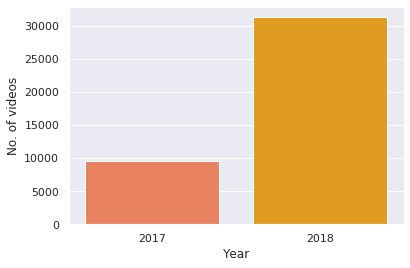

In [0]:
# See the years in which the Canada dataset was collected
cdf = ca["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos")

In [0]:
# Convert trending_date and publish_time to datetime datatype
ca.trending_date = pd.to_datetime(ca.trending_date, format = '%y.%d.%m')
ca.publish_time = pd.to_datetime(ca.publish_time)

In [0]:
ca.trending_date.head()

0   2017-11-14
1   2017-11-14
2   2017-11-14
3   2017-11-14
4   2017-11-14
Name: trending_date, dtype: datetime64[ns]

In [0]:
# Find the top 10 videos in Canada and the number of times they're on the trending list 
ca.title.value_counts()[:10]

Drake - God's Plan (Official Audio)                                                                  15
Most Popular Violin Covers of Popular Songs 2018 || Best Instrumental Violin Covers 2018             15
Bruno Mars,Charlie Puth,Ed Sheeran Best Christmas Songs,Greatest Hits Pop Playlist Christmas 2018    13
Deleted video                                                                                        11
Merry Christmas 2018 - Top Christmas Songs Playlist 2018 - Best Christmas Songs Ever                 10
Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures                          9
Nicki Minaj - Chun-Li                                                                                 9
Maroon 5 - Wait                                                                                       9
G-Eazy - No Limit REMIX ft. A$AP Rocky, Cardi B, French Montana, Juicy J, Belly                       8
Childish Gambino - This Is America (Official Video)             

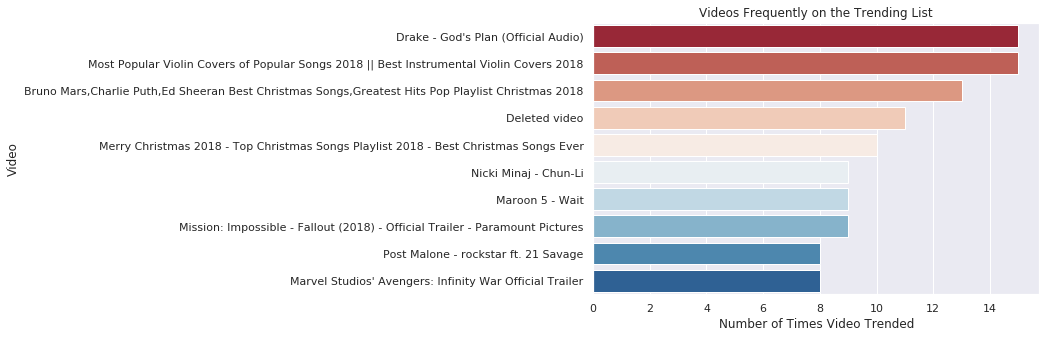

In [0]:
# Visualize top 10 most popular videos in Canada and the number of times they're on the trending list 
ca_pop_video = ca.groupby("title").size().reset_index(name="trending_count") \
    .sort_values("trending_count", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="trending_count", y="title", data=ca_pop_video,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Number of Times Video Trended", ylabel="Video", 
           title = 'Videos Frequently on the Trending List')

In [0]:
# Find the top 10 most popular channels in Canada and the number of times their videos are on the trending list
ca.channel_title.value_counts()[:10]

SET India                             192
MSNBC                                 189
FBE                                   188
The Young Turks                       186
REACT                                 183
VikatanTV                             182
CNN                                   182
The Late Show with Stephen Colbert    172
ARY Digital                           168
RadaanMedia                           168
Name: channel_title, dtype: int64

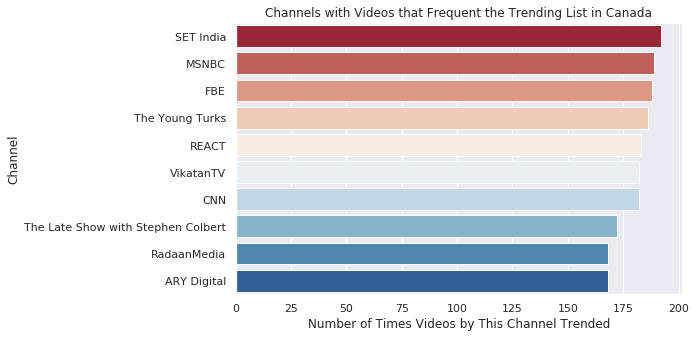

In [0]:
# Visualize top 10 most popular channels in Canada and the number of times their videos are on the trending list
ca_pop_channel = ca.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="video_count", y="channel_title", data=ca_pop_channel,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Number of Times Videos by This Channel Trended", ylabel="Channel", 
           title = 'Channels with Videos that Frequent the Trending List in Canada')

Above visualizations give us an understanding of the videos and channels that frequently appeared on the trending videos list in Canada. Let's do some more data manipultion to find out the most viewed videos in Canada. 

In [0]:
# Find the 10 most viewed videos in Canada 
# Since a video could appear on the trending list multiple times, find the max views for each video since Youtube 

ca_by_views = pd.DataFrame(ca.groupby(['video_id','title'])['views'].max().\
                           sort_values(ascending = False).reset_index(name = "total views").head(10))
ca_by_views.head()

video_id                                              title  total views
0  FlsCjmMhFmw  YouTube Rewind: The Shape of 2017 | #YouTubeRe...    137843120
1  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...     98938809
2  6ZfuNTqbHE8  Marvel Studios' Avengers: Infinity War Officia...     89930713
3  7C2z4GqqS5E                BTS (방탄소년단) 'FAKE LOVE' Official MV     80738011
4  _I_D_8Z4sJE  Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...     61163906

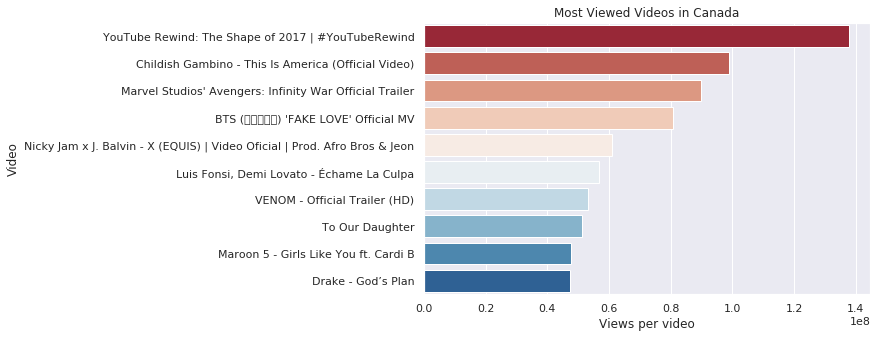

In [0]:
# Visualize top 10 most viewed videos in Canada
ca_by_views = pd.DataFrame(ca.groupby(['video_id','title'])['views'].max().\
                           sort_values(ascending = False).reset_index(name = "total views").head(10))

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="total views", y="title", data=ca_by_views,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Views per video", ylabel="Video", 
           title = 'Most Viewed Videos in Canada')

Interestingly, the most viewed videos are different from the videos that appeared the most on the trending board. The most viewed video has close to 140 million views! That's more than 40% of the US population! 

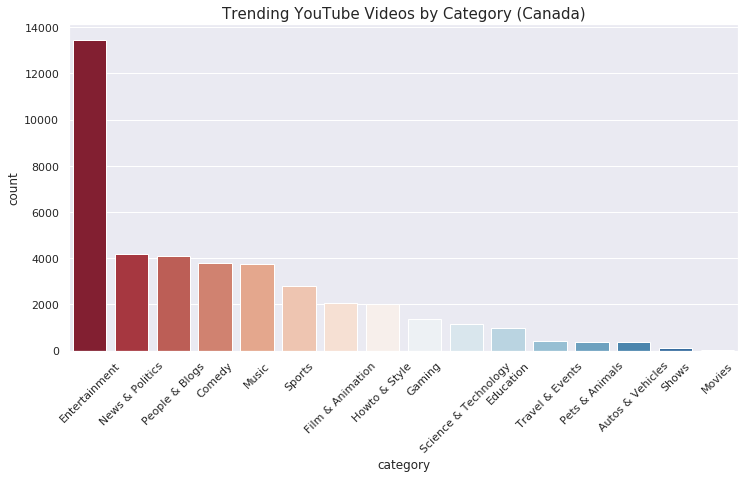

In [0]:
# Visualize the number of trending videos by category
fig, ax = plt.subplots(figsize=(12, 6))

count = sns.countplot(data = ca, x = 'category', order = ca.category.value_counts().index, palette = 'RdBu')
count.set_xticklabels(count.get_xticklabels(), rotation = 45)
count.set_title('Trending YouTube Videos by Category (Canada)', fontsize = 15)
plt.show()

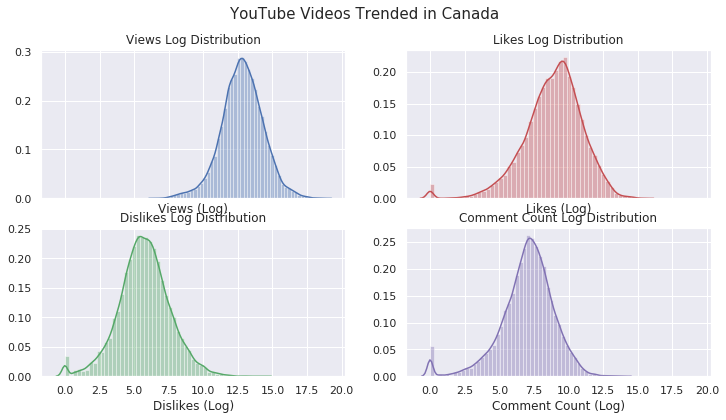

In [0]:
# Distribution plot of views, likes, dislikes, and comment_count of videos trended in Canada
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex = True)

f1 = sns.distplot(np.log(ca.views + 1), color='b', ax=axes[0, 0])
f1.set_xlabel('Views (Log)')
f1.set_title('Views Log Distribution')

f2 = sns.distplot(np.log(ca.likes + 1), color='r', ax=axes[0, 1])
f2.set_xlabel('Likes (Log)')
f2.set_title('Likes Log Distribution')

f3 = sns.distplot(np.log(ca.dislikes + 1), color='g', ax=axes[1, 0])
f3.set_xlabel('Dislikes (Log)')
f3.set_title('Dislikes Log Distribution')

f4 = sns.distplot(np.log(ca.comment_count + 1), color='m', ax=axes[1, 1])
f4.set_xlabel('Comment Count (Log)')
f4.set_title('Comment Count Log Distribution')

fig.suptitle('YouTube Videos Trended in Canada', fontsize = 15)
plt.show()

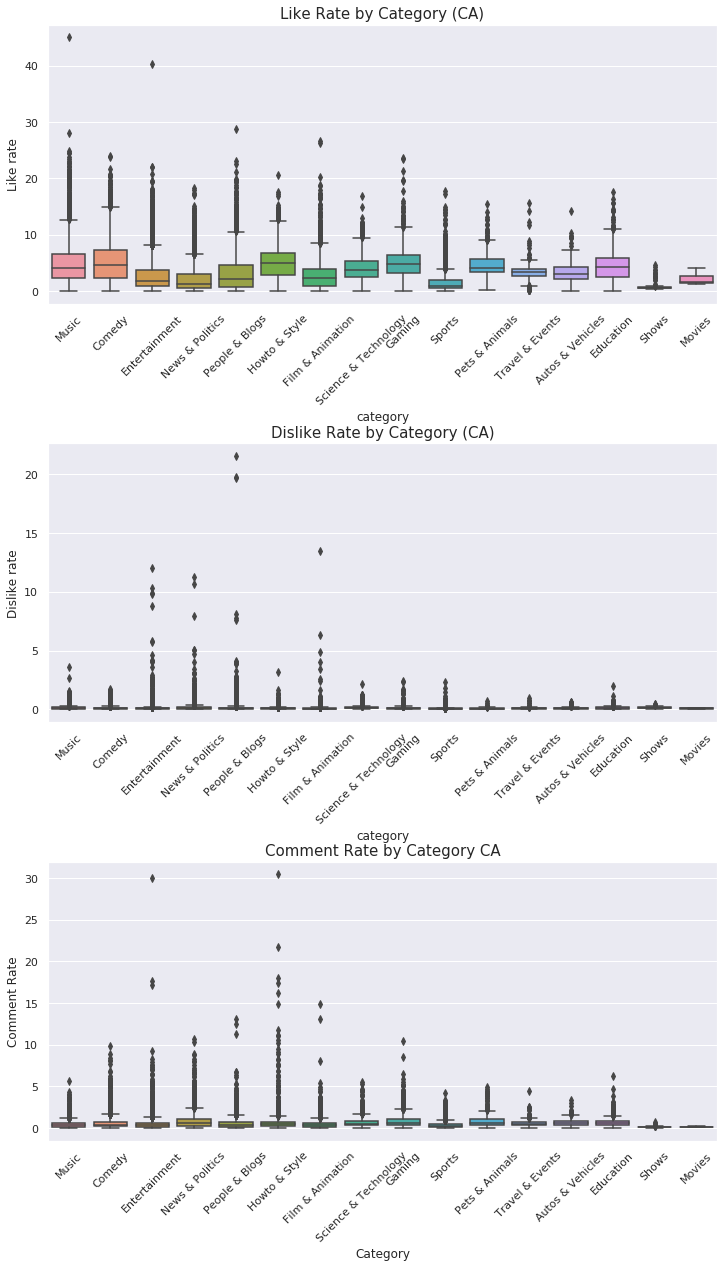

In [0]:
# Create 3 variables that help us understand viewer engagement 
ca['like_rate'] =  ca['likes'] / ca['views'] * 100
ca['dislike_rate'] =  ca['dislikes'] / ca['views'] * 100
ca['comment_rate'] =  ca['comment_count'] / ca['views'] * 100

plt.figure(figsize = (12,20))

plt.subplot(311)
g= sns.boxplot(x='category', y='like_rate', data=ca)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Like Rate by Category (CA)", fontsize=15)
g.set_ylabel("Like rate", fontsize=12)

plt.subplot(312)
g1= sns.boxplot(x='category', y='dislike_rate', data=ca)
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Dislike Rate by Category (CA)", fontsize=15)
g1.set_ylabel("Dislike rate", fontsize=12)

plt.subplot(313)
g2= sns.boxplot(x='category', y='comment_rate', data=ca)
g2.set_xticklabels(g.get_xticklabels(),rotation=45)
g2.set_title("Comment Rate by Category CA", fontsize=15)
g2.set_xlabel("Category", fontsize=12)
g2.set_ylabel("Comment Rate", fontsize=12)

plt.subplots_adjust(wspace = 0.2, hspace = 0.5,top = 0.9)

plt.show()

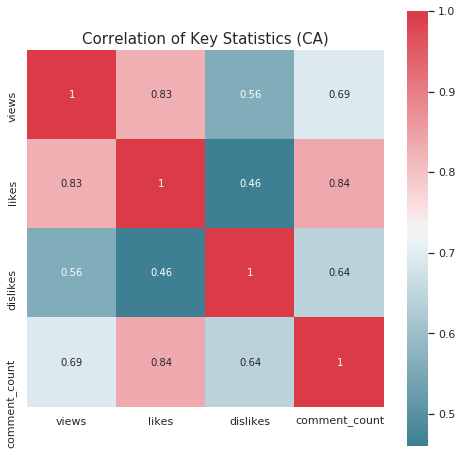

In [0]:
# Correlation heatmap of views, likes, dislikes, and comment count for videos trending in Canada
metric_cols = ['views', 'likes', 'dislikes', 'comment_count']

plt.figure(figsize=(8, 8))

corr = ca[metric_cols].corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, annot = True)
plt.title("Correlation of Key Statistics (CA)", fontsize=15)

plt.show()

We see all across positive correlation. High correlation between views and likes as well as likes and comment_count. 

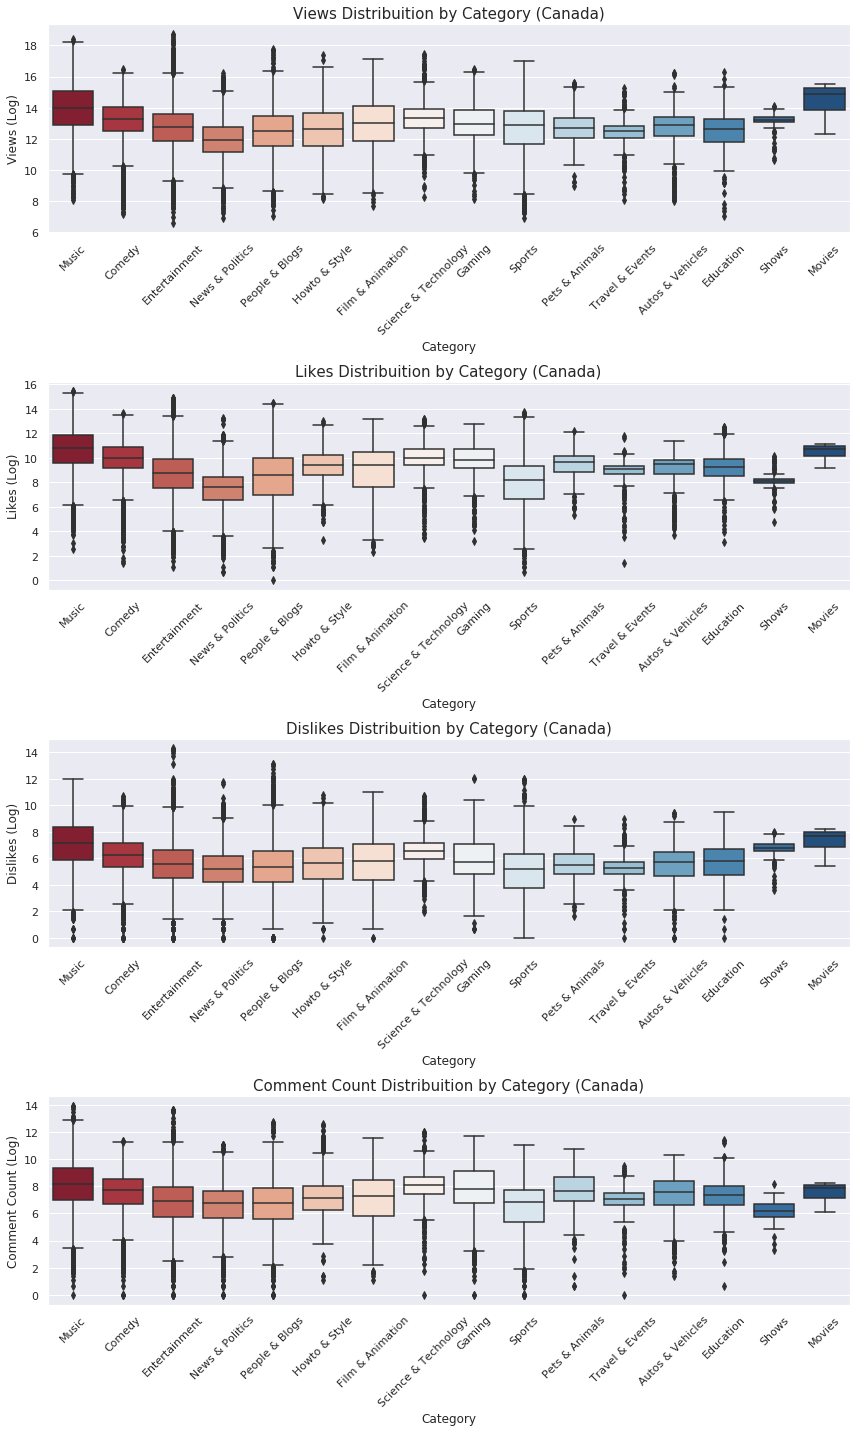

In [0]:
# Boxplot of views, likes, dislikes, and comment_count by category for videos trending in Canada
fig, axes = plt.subplots(4, figsize=(12,20))

views = sns.boxplot(x = 'category', y = np.log(ca.views), data = ca, palette = 'RdBu', ax = axes[0])
views.set_xticklabels(views.get_xticklabels(), rotation = 45)
views.set_xlabel('Category', fontsize = 12)
views.set_ylabel('Views (Log)', fontsize=12)
views.set_title('Views Distribuition by Category (Canada)', fontsize = 15)

likes = sns.boxplot(x = 'category', y = np.log(ca.likes), data = ca, palette = 'RdBu', ax = axes[1])
likes.set_xticklabels(likes.get_xticklabels(), rotation = 45)
likes.set_xlabel('Category', fontsize = 12)
likes.set_ylabel('Likes (Log)', fontsize=12)
likes.set_title('Likes Distribuition by Category (Canada)', fontsize = 15)

dislikes = sns.boxplot(x = 'category', y = np.log(ca.dislikes), data = ca, palette = 'RdBu', ax = axes[2])
dislikes.set_xticklabels(dislikes.get_xticklabels(), rotation = 45)
dislikes.set_xlabel('Category', fontsize = 12)
dislikes.set_ylabel('Dislikes (Log)', fontsize=12)
dislikes.set_title('Dislikes Distribuition by Category (Canada)', fontsize = 15)

comments = sns.boxplot(x = 'category', y = np.log(ca.comment_count), data = ca, palette = 'RdBu', ax = axes[3])
comments.set_xticklabels(comments.get_xticklabels(), rotation = 45)
comments.set_xlabel('Category', fontsize = 12)
comments.set_ylabel('Comment Count (Log)', fontsize=12)
comments.set_title('Comment Count Distribuition by Category (Canada)', fontsize = 15)
plt.tight_layout()

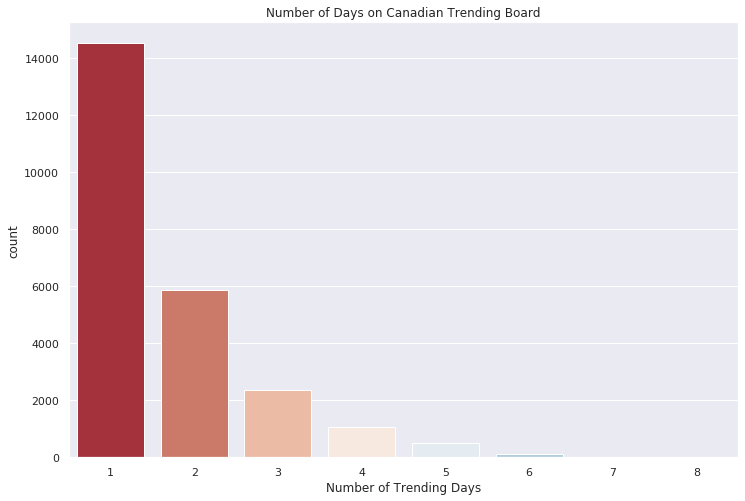

In [0]:
# Visualize the number of trending days per video
trending_days = pd.DataFrame(ca.groupby('video_id').size())
trending_days.columns = ['num_trending_days']

plt.figure(figsize = (12, 8))

sns.countplot(trending_days.num_trending_days, palette = 'RdBu')
plt.xlabel('Number of Trending Days')
plt.title('Number of Days on Canadian Trending Board')

plt.show()

###Tags

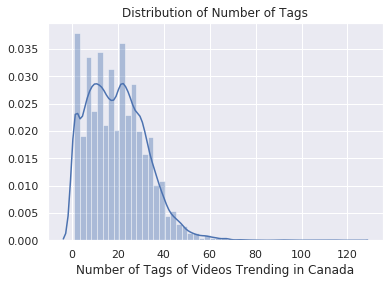

In [0]:
# Distribution plot of the number of tags per video
catags_per_vid = ca.tags.apply(lambda x: len(x.split("|")))
sns.distplot(catags_per_vid)
plt.xlabel('Number of Tags of Videos Trending in Canada')
plt.title('Distribution of Number of Tags')
plt.show()

In [0]:
catags = " ".join(review for review in ca.tags)
print ("There are {} words in the combination of all review.".format(len(catags)))

There are 11408278 words in the combination of all review.


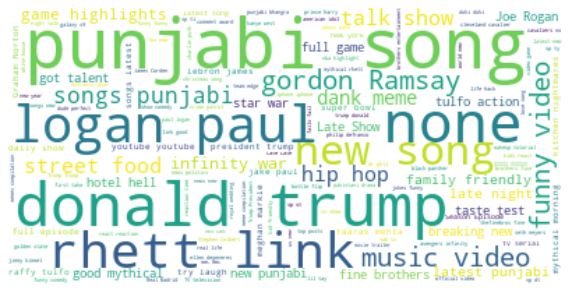

In [0]:
# Load necessary libraries for wordcloud
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(catags)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Title

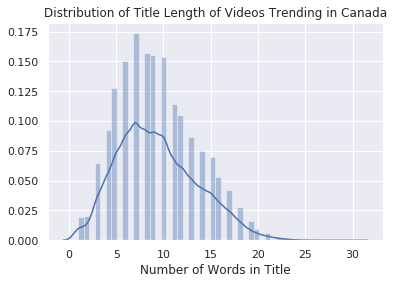

In [0]:
# Distribution plot of title length by wordcount 
catitle_length = ca.title.apply(lambda x: len(x.split()))
sns.distplot(catitle_length)
plt.xlabel('Number of Words in Title')
plt.title('Distribution of Title Length of Videos Trending in Canada')
plt.show()

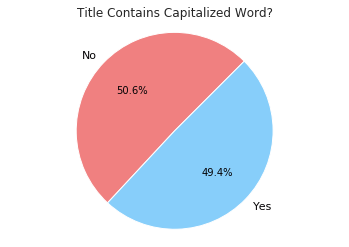

In [0]:
# Visualize the percentage of video titles contain all capitalized words 
# Note: all capitalized word is a word where all characters are capitalized, eg "ALL". "Hello", with only 1 character capitalized, is not considered all cap.
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False

ca["title_contain_cap"] = ca["title"].apply(contains_capitalized_word)

value_counts = ca["title_contain_cap"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['lightcoral', 'lightskyblue'], textprops={'color': '#040204'}, autopct='%1.1f%%', startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Title Contains Capitalized Word?')

In [0]:
catitle = " ".join(review for review in ca.title)
print ("There are {} words in the combination of all review.".format(len(catitle)))

There are 2236568 words in the combination of all review.


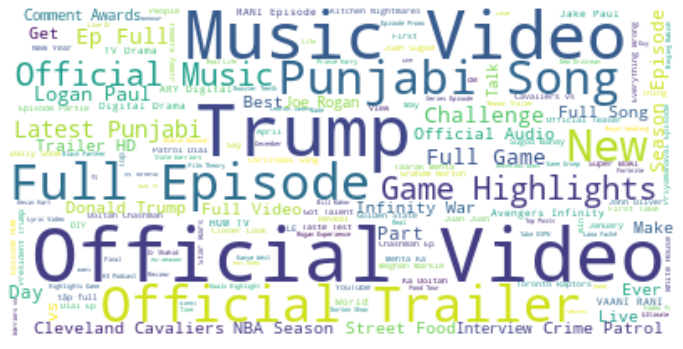

In [0]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(catitle)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (12, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Description

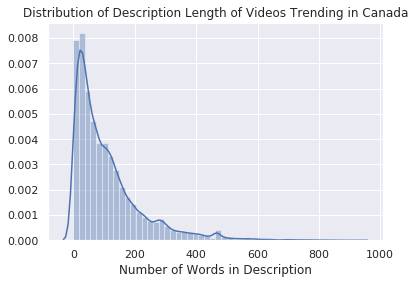

In [0]:
# Distribution plot of description length by wordcount 

cadesc_length = ca.description.apply(lambda x: len(x.split()) if type(x) != float else 0)
sns.distplot(cadesc_length) 
plt.xlabel('Number of Words in Description')
plt.title('Distribution of Description Length of Videos Trending in Canada')
plt.show()

##United Kingdom

In [0]:
gb.shape

(38916, 17)

In [0]:
gb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38916 entries, 0 to 38915
Data columns (total 17 columns):
video_id                  38916 non-null object
trending_date             38916 non-null object
title                     38916 non-null object
channel_title             38916 non-null object
category_id               38916 non-null int64
publish_time              38916 non-null object
tags                      38916 non-null object
views                     38916 non-null int64
likes                     38916 non-null int64
dislikes                  38916 non-null int64
comment_count             38916 non-null int64
thumbnail_link            38916 non-null object
comments_disabled         38916 non-null bool
ratings_disabled          38916 non-null bool
video_error_or_removed    38916 non-null bool
description               38304 non-null object
category                  38826 non-null object
dtypes: bool(3), int64(5), object(9)
memory usage: 4.6+ MB


In [0]:
# Check for missing values in GB dataset
check_missing(gb)

# We see small numbers of missing values in description and category features. 

Out of 17 columns, 2 columns have missing values


Missing Values  % Missing
video_id                             0       0.00
trending_date                        0       0.00
title                                0       0.00
channel_title                        0       0.00
category_id                          0       0.00
publish_time                         0       0.00
tags                                 0       0.00
views                                0       0.00
likes                                0       0.00
dislikes                             0       0.00
comment_count                        0       0.00
thumbnail_link                       0       0.00
comments_disabled                    0       0.00
ratings_disabled                     0       0.00
video_error_or_removed               0       0.00
description                        612       1.57
category                            90       0.23

In [0]:
gb.head()

video_id  ...         category
0  Jw1Y-zhQURU  ...    Howto & Style
1  3s1rvMFUweQ  ...    Entertainment
2  n1WpP7iowLc  ...            Music
3  PUTEiSjKwJU  ...           Sports
4  rHwDegptbI4  ...  News & Politics

[5 rows x 17 columns]

In [0]:
gb.describe(include = 'all')

video_id  ... category
count         38916  ...    38826
unique         3272  ...       15
top     BhIEIO0vaBE  ...    Music
freq             38  ...    13754
mean            NaN  ...      NaN
std             NaN  ...      NaN
min             NaN  ...      NaN
25%             NaN  ...      NaN
50%             NaN  ...      NaN
75%             NaN  ...      NaN
max             NaN  ...      NaN

[11 rows x 17 columns]

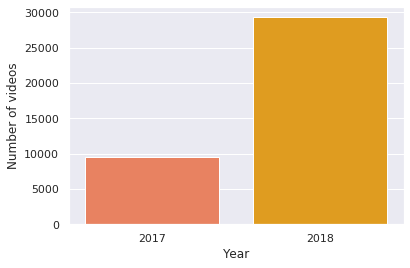

In [0]:
# See the years in which the GB dataset was collected
gdf = gb["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=gdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="Number of videos")

In [0]:
# convert trending_date and publish_time to datetime datatype
gb.trending_date = pd.to_datetime(gb.trending_date, format = '%y.%d.%m')
gb.publish_time = pd.to_datetime(gb.publish_time)

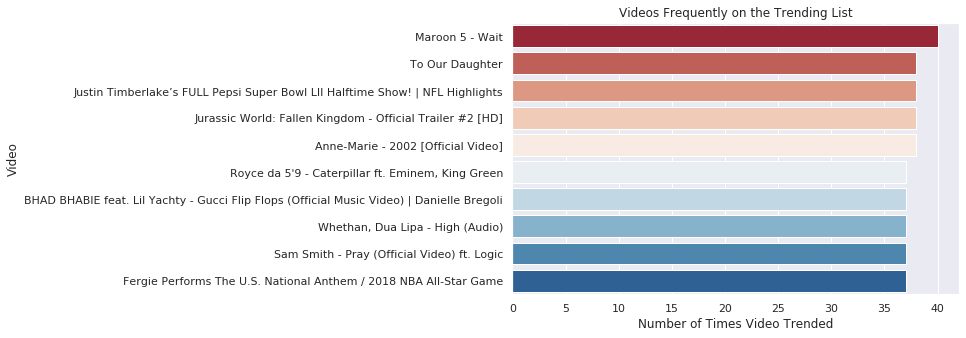

In [0]:
# Visualize top 10 most popular videos in UK and the number of times they're on the trending list 
uk_pop_video = gb.groupby("title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="video_count", y="title", data=uk_pop_video,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Number of Times Video Trended", ylabel="Video", 
           title = 'Videos Frequently on the Trending List')

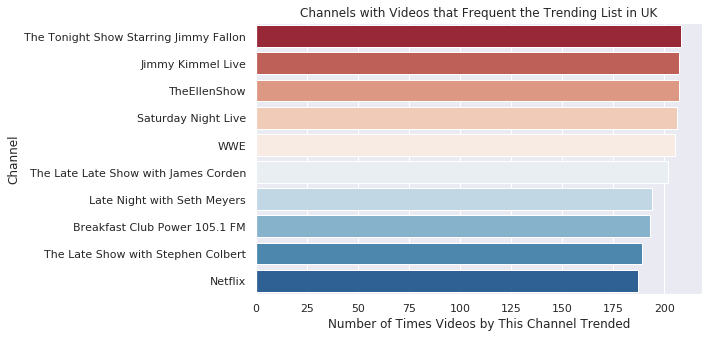

In [0]:
# Visualize top 10 most popular channels in Canada and the number of times their videos are on the trending list
uk_pop_channel = gb.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="video_count", y="channel_title", data=uk_pop_channel,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Number of Times Videos by This Channel Trended", ylabel="Channel", 
           title = 'Channels with Videos that Frequent the Trending List in UK')

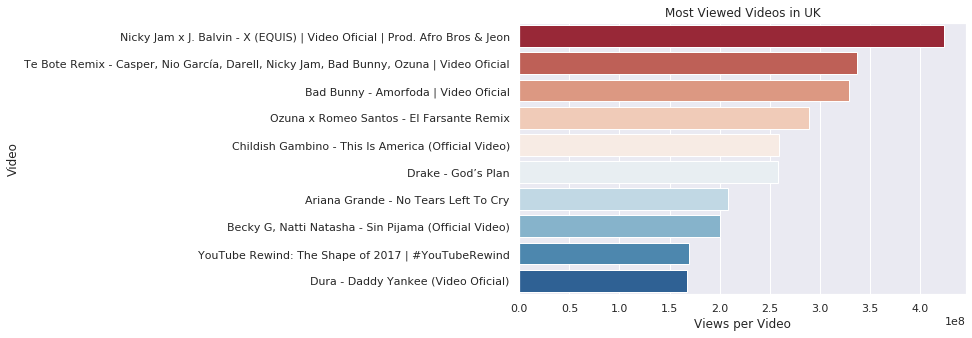

In [0]:
# Visualize top 10 most viewed videos in UK
gb_by_views = pd.DataFrame(gb.groupby(['video_id','title'])['views'].max().\
                           sort_values(ascending = False).reset_index(name = "total views").head(10))

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="total views", y="title", data=gb_by_views,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Views per Video", ylabel="Video", 
           title = 'Most Viewed Videos in UK')

Again, the most viewed videos are different from the videos that appeared the most on the trending board. Some videos on the chart are also among the most viewed in Canada, but the top videos in UK each has significantly more views than those in Canada. The top video has over 400 million views!

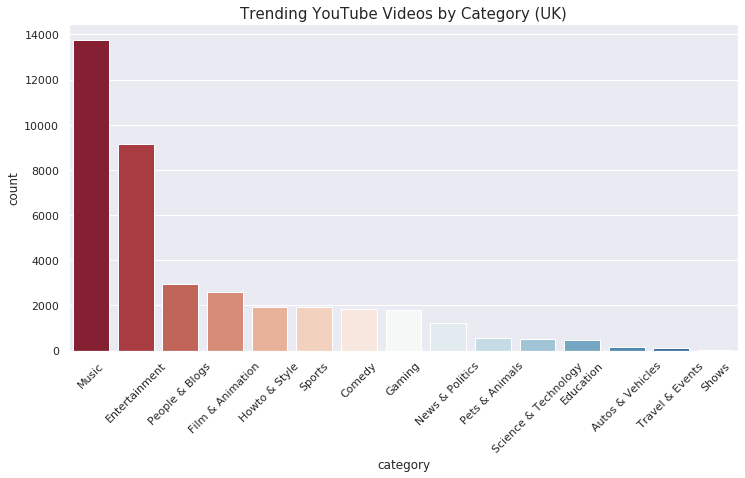

In [0]:
# Visualize the number of trending videos by category
fig, ax = plt.subplots(figsize=(12, 6))

count = sns.countplot(data = gb, x = 'category', order = gb.category.value_counts().index, palette = 'RdBu')
count.set_xticklabels(count.get_xticklabels(), rotation = 45)
count.set_title('Trending YouTube Videos by Category (UK)', fontsize = 15)
plt.show()

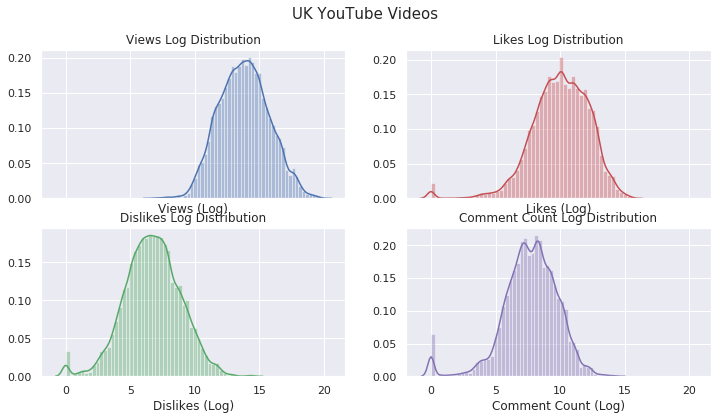

In [0]:
# Distribution plot of views, likes, dislikes, and comment_count
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex = True)

f1 = sns.distplot(np.log(gb.views + 1), color='b', ax=axes[0, 0])
f1.set_xlabel('Views (Log)')
f1.set_title('Views Log Distribution')

f2 = sns.distplot(np.log(gb.likes + 1), color='r', ax=axes[0, 1])
f2.set_xlabel('Likes (Log)')
f2.set_title('Likes Log Distribution')

f3 = sns.distplot(np.log(gb.dislikes + 1), color='g', ax=axes[1, 0])
f3.set_xlabel('Dislikes (Log)')
f3.set_title('Dislikes Log Distribution')

f4 = sns.distplot(np.log(gb.comment_count + 1), color='m', ax=axes[1, 1])
f4.set_xlabel('Comment Count (Log)')
f4.set_title('Comment Count Log Distribution')

fig.suptitle('UK YouTube Videos', fontsize = 15)
plt.show()

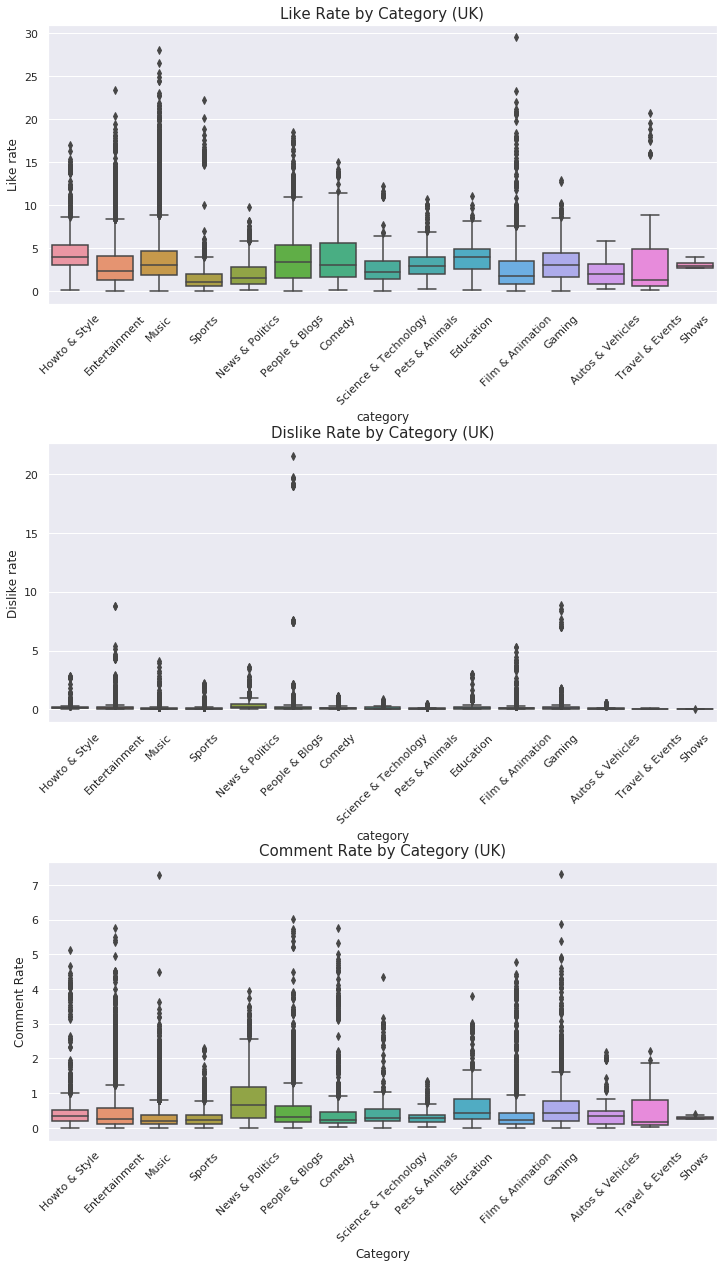

In [0]:
# Create 3 variables that help us understand viewer engagement 
gb['like_rate'] =  gb['likes'] / gb['views'] * 100
gb['dislike_rate'] =  gb['dislikes'] / gb['views'] * 100
gb['comment_rate'] =  gb['comment_count'] / gb['views'] * 100

plt.figure(figsize = (12,20))

plt.subplot(311)
g= sns.boxplot(x='category', y='like_rate', data=gb)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Like Rate by Category (UK)", fontsize=15)
g2.set_xlabel("Category", fontsize=12)
g.set_ylabel("Like rate", fontsize=12)

plt.subplot(312)
g1= sns.boxplot(x='category', y='dislike_rate', data=gb)
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Dislike Rate by Category (UK)", fontsize=15)
g2.set_xlabel("Category", fontsize=12)
g1.set_ylabel("Dislike rate", fontsize=12)

plt.subplot(313)
g2= sns.boxplot(x='category', y='comment_rate', data=gb)
g2.set_xticklabels(g.get_xticklabels(),rotation=45)
g2.set_title("Comment Rate by Category (UK)", fontsize=15)
g2.set_xlabel("Category", fontsize=12)
g2.set_ylabel("Comment Rate", fontsize=12)

plt.subplots_adjust(wspace = 0.2, hspace = 0.5,top = 0.9)

plt.show()

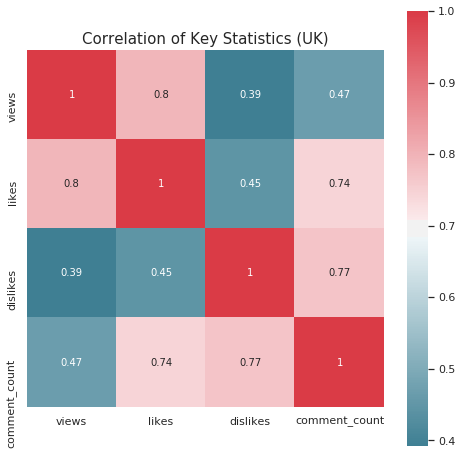

In [0]:
# Correlation heatmap of views, likes, dislikes, and comment count for videos trending in UK 
plt.figure(figsize=(8, 8))

corr = gb[metric_cols].corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, annot = True)
plt.title("Correlation of Key Statistics (UK)", fontsize=15)

plt.show()

Compared to Canada we see lower correlation between views and dislikes, views and comment_count, as well as likes and comment count. We also see higher correlation between dislikes and comment count. 

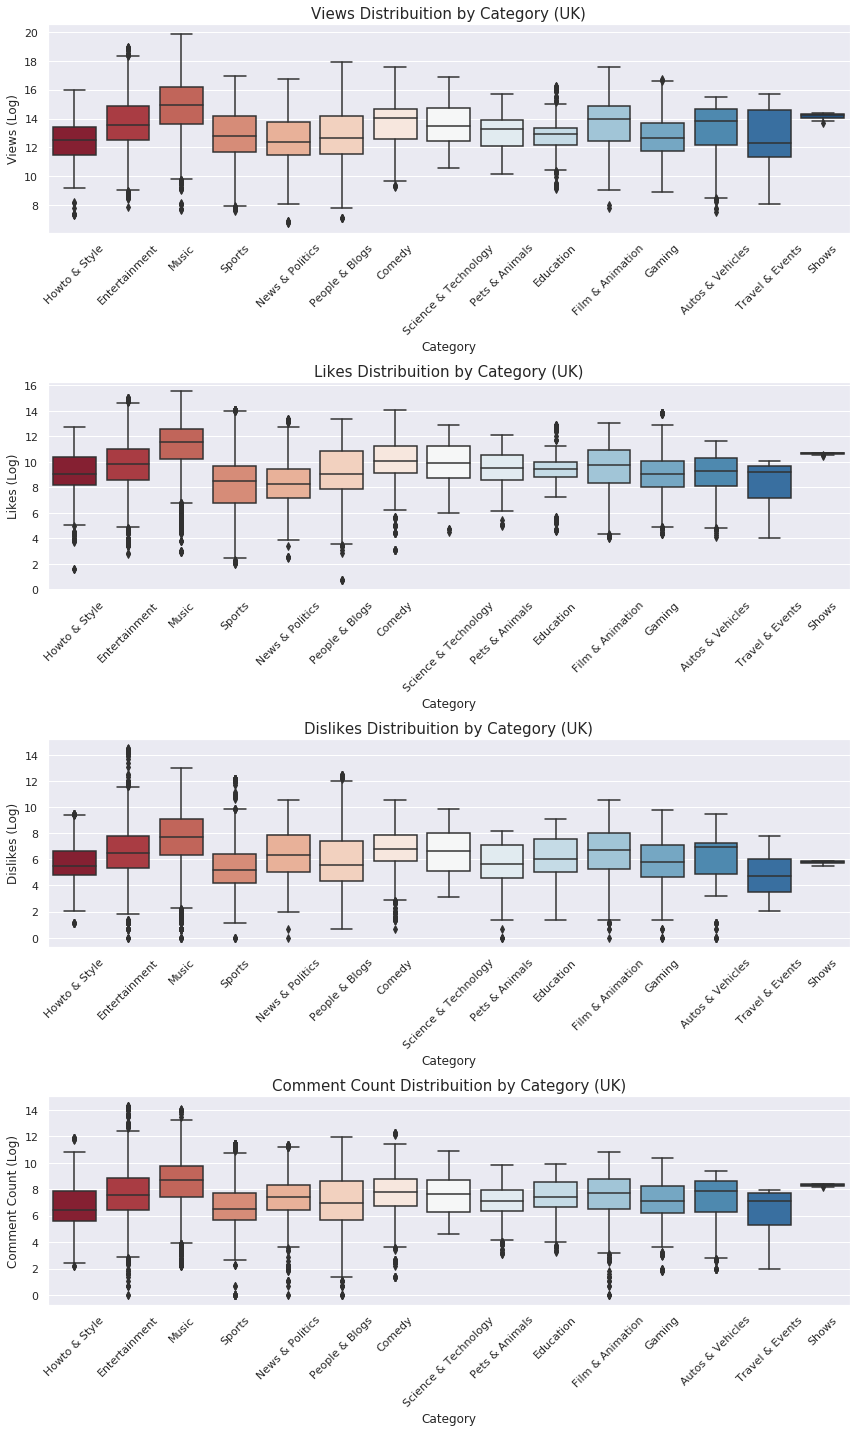

In [0]:
# Boxplot of views, likes, dislikes, and comment_count by category
fig, axes = plt.subplots(4, figsize=(12,20))

views = sns.boxplot(x = 'category', y = np.log(gb.views), data = gb, palette = 'RdBu', ax = axes[0])
views.set_xticklabels(views.get_xticklabels(), rotation = 45)
views.set_xlabel('Category', fontsize = 12)
views.set_ylabel('Views (Log)', fontsize=12)
views.set_title('Views Distribuition by Category (UK)', fontsize = 15)

likes = sns.boxplot(x = 'category', y = np.log(gb.likes), data = gb, palette = 'RdBu', ax = axes[1])
likes.set_xticklabels(likes.get_xticklabels(), rotation = 45)
likes.set_xlabel('Category', fontsize = 12)
likes.set_ylabel('Likes (Log)', fontsize=12)
likes.set_title('Likes Distribuition by Category (UK)', fontsize = 15)

dislikes = sns.boxplot(x = 'category', y = np.log(gb.dislikes), data = gb, palette = 'RdBu', ax = axes[2])
dislikes.set_xticklabels(dislikes.get_xticklabels(), rotation = 45)
dislikes.set_xlabel('Category', fontsize = 12)
dislikes.set_ylabel('Dislikes (Log)', fontsize=12)
dislikes.set_title('Dislikes Distribuition by Category (UK)', fontsize = 15)

comments = sns.boxplot(x = 'category', y = np.log(gb.comment_count), data = gb, palette = 'RdBu', ax = axes[3])
comments.set_xticklabels(comments.get_xticklabels(), rotation = 45)
comments.set_xlabel('Category', fontsize = 12)
comments.set_ylabel('Comment Count (Log)', fontsize=12)
comments.set_title('Comment Count Distribuition by Category (UK)', fontsize = 15)
plt.tight_layout()

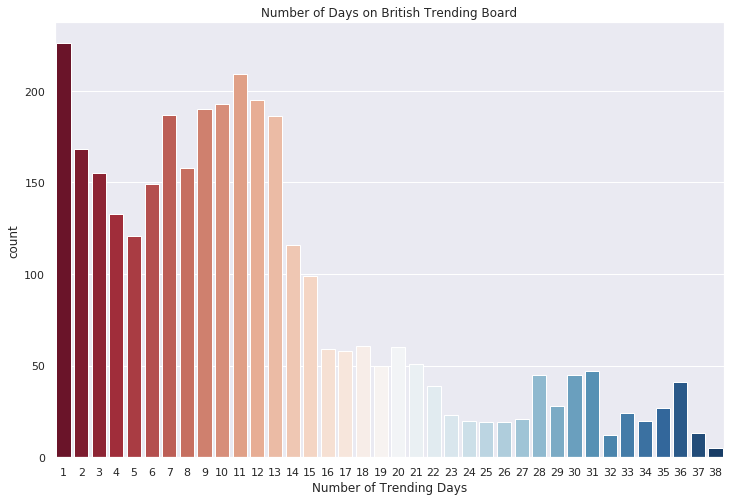

In [0]:
# Visualize the number of trending days per video
trending_days = pd.DataFrame(gb.groupby('video_id').size())
trending_days.columns = ['num_trending_days']

plt.figure(figsize = (12, 8))
sns.countplot(trending_days.num_trending_days, palette = 'RdBu')
plt.xlabel('Number of Trending Days')
plt.title('Number of Days on British Trending Board')
plt.show()

Compared to Canada where most videos trend for 1 day, videos tend to trend for much longer in the UK. 

Tags

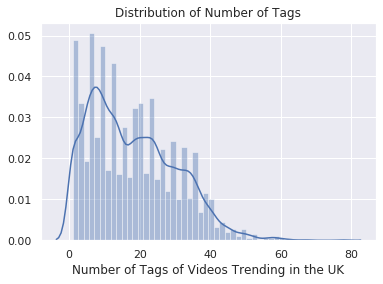

In [0]:
# Distribution plot of the number of tags per video
gbtags_per_vid = gb.tags.apply(lambda x: len(x.split("|")))
sns.distplot(gbtags_per_vid)
plt.xlabel('Number of Tags of Videos Trending in the UK')
plt.title('Distribution of Number of Tags')
plt.show()

In [0]:
gbtags = " ".join(review for review in gb.tags)
print ("There are {} words in the combination of all review.".format(len(gbtags)))

There are 9586952 words in the combination of all review.


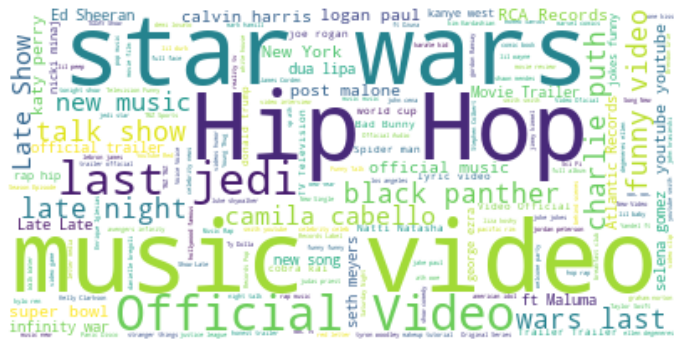

In [0]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(gbtags)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Title

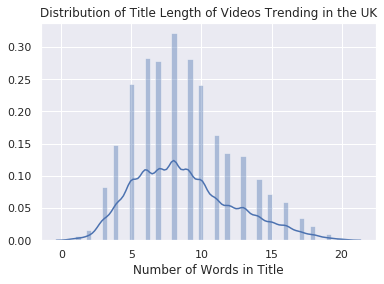

In [0]:
# Distribution plot of title length by word count
gbtitle_length = gb.title.apply(lambda x: len(x.split()))
sns.distplot(gbtitle_length)
plt.xlabel('Number of Words in Title')
plt.title('Distribution of Title Length of Videos Trending in the UK')
plt.show()

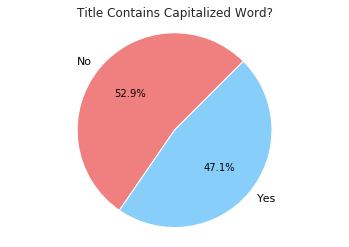

In [0]:
# Visualize the percentage of video titles contain all capitalized words 
gb["title_contain_cap"] = gb["title"].apply(contains_capitalized_word)

value_counts = gb["title_contain_cap"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['lightcoral', 'lightskyblue'], textprops={'color': '#040204'}, autopct='%1.1f%%', startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Title Contains Capitalized Word?')

In [0]:
gbtitle = " ".join(review for review in gb.title)
print ("There are {} words in the combination of all review.".format(len(gbtitle)))

There are 1967194 words in the combination of all review.


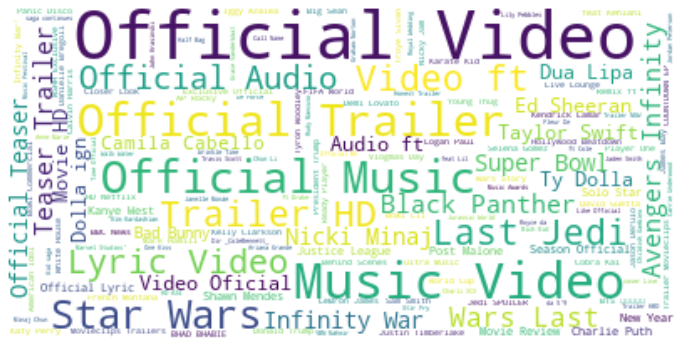

In [0]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(gbtitle)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Description

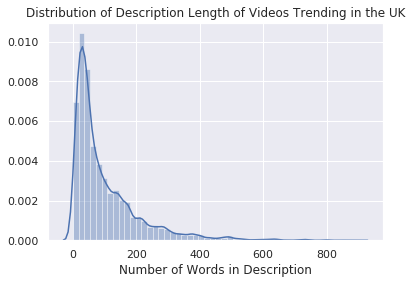

In [0]:
# Distribution plot of description length by wordcount 

gbdesc_length = gb.description.apply(lambda x: len(x.split()) if type(x) != float else 0)
sns.distplot(gbdesc_length) 
plt.xlabel('Number of Words in Description')
plt.title('Distribution of Description Length of Videos Trending in the UK')
plt.show()

##United States

In [0]:
us.shape

(40949, 17)

In [0]:
us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40949 entries, 0 to 40948
Data columns (total 17 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
category                  40949 non-null object
dtypes: bool(3), int64(5), object(9)
memory usage: 4.8+ MB


In [0]:
# Check for missing values in the US dataset
check_missing(us)

# We see small amounts of missing values in the description feature. 

Out of 17 columns, 1 columns have missing values


Missing Values  % Missing
video_id                             0       0.00
trending_date                        0       0.00
title                                0       0.00
channel_title                        0       0.00
category_id                          0       0.00
publish_time                         0       0.00
tags                                 0       0.00
views                                0       0.00
likes                                0       0.00
dislikes                             0       0.00
comment_count                        0       0.00
thumbnail_link                       0       0.00
comments_disabled                    0       0.00
ratings_disabled                     0       0.00
video_error_or_removed               0       0.00
description                        570       1.39
category                             0       0.00

In [0]:
us.head()

video_id  ...        category
0  2kyS6SvSYSE  ...  People & Blogs
1  1ZAPwfrtAFY  ...   Entertainment
2  5qpjK5DgCt4  ...          Comedy
3  puqaWrEC7tY  ...   Entertainment
4  d380meD0W0M  ...   Entertainment

[5 rows x 17 columns]

In [0]:
us.describe(include = 'all')

video_id  ...       category
count         40949  ...          40949
unique         6351  ...             16
top     j4KvrAUjn6c  ...  Entertainment
freq             30  ...           9964
mean            NaN  ...            NaN
std             NaN  ...            NaN
min             NaN  ...            NaN
25%             NaN  ...            NaN
50%             NaN  ...            NaN
75%             NaN  ...            NaN
max             NaN  ...            NaN

[11 rows x 17 columns]

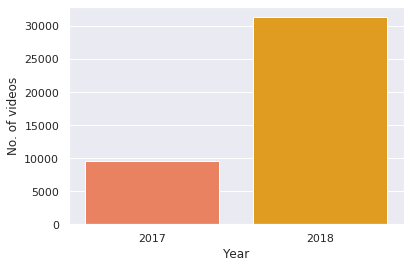

In [0]:
# See the years in which the US dataset was collected
usdf = us["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=usdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos")

In [0]:
# Convert trending_date and publish_time to datetime datatype
us.trending_date = pd.to_datetime(us.trending_date, format = '%y.%d.%m')
us.publish_time = pd.to_datetime(us.publish_time)

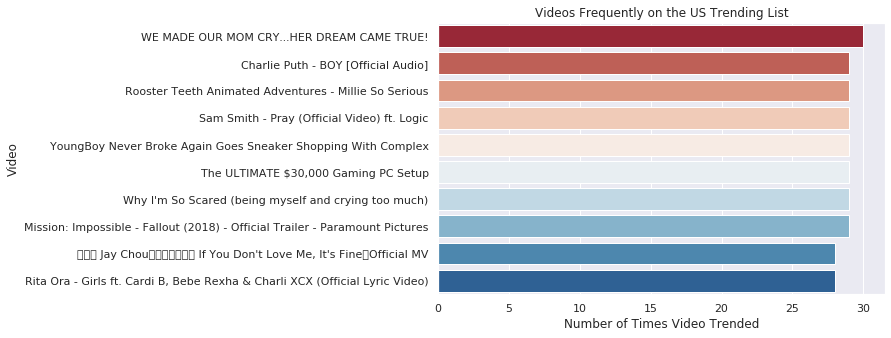

In [0]:
# Visualize top 10 most popular videos in US and the number of times they were on the trending list 
us_pop_video = us.groupby("title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="video_count", y="title", data=us_pop_video,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Number of Times Video Trended", ylabel="Video", 
           title = 'Videos Frequently on the US Trending List')

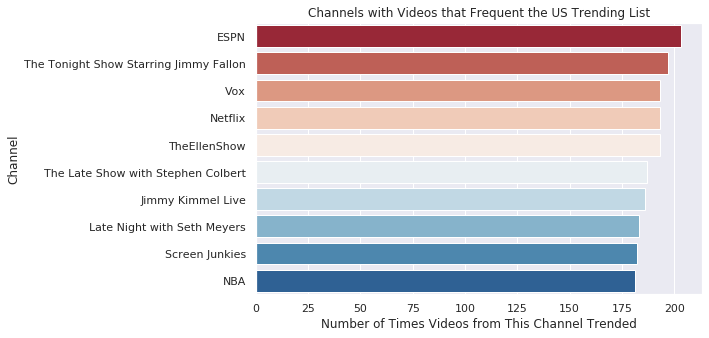

In [0]:
# Visualize top 10 most popular channels in US and the number of times their videos are on the trending list
us_pop_channel = us.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="video_count", y="channel_title", data=us_pop_channel,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Number of Times Videos from This Channel Trended", ylabel="Channel", 
           title = 'Channels with Videos that Frequent the US Trending List')

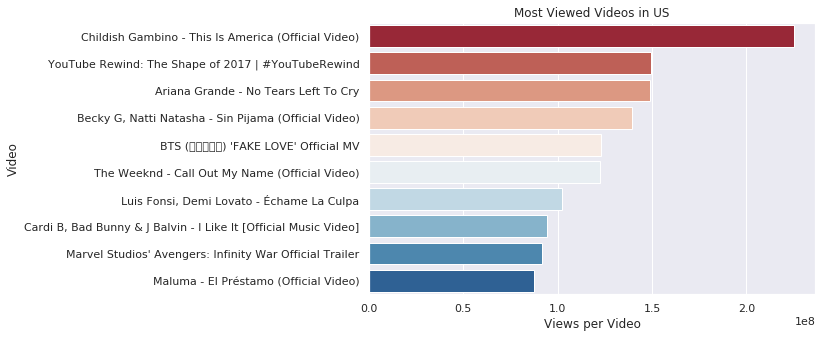

In [0]:
# Visualize top 10 most viewed videos in US
us_by_views = pd.DataFrame(us.groupby(['video_id','title'])['views'].max().\
                           sort_values(ascending = False).reset_index(name = "total views").head(10))

fig, ax = plt.subplots(figsize=(8,5))
_ = sns.barplot(x="total views", y="title", data=us_by_views,
                palette='RdBu', ax=ax)
_ = ax.set(xlabel="Views per Video", ylabel="Video", 
           title = 'Most Viewed Videos in US')

Again we see overlap of most viewed videos with those in Canada and the UK. While the most viewed video has around 230 million views, the other top views are in the 100-150 million range. 

In [0]:
us_by_views

video_id                                              title  total views
0  VYOjWnS4cMY  Childish Gambino - This Is America (Official V...    225211923
1  FlsCjmMhFmw  YouTube Rewind: The Shape of 2017 | #YouTubeRe...    149376127
2  ffxKSjUwKdU               Ariana Grande - No Tears Left To Cry    148689896
3  zEf423kYfqk  Becky G, Natti Natasha - Sin Pijama (Official ...    139334502
4  7C2z4GqqS5E                BTS (방탄소년단) 'FAKE LOVE' Official MV    123010920
5  M4ZoCHID9GI     The Weeknd - Call Out My Name (Official Video)    122544931
6  TyHvyGVs42U          Luis Fonsi, Demi Lovato - Échame La Culpa    102012605
7  xTlNMmZKwpA  Cardi B, Bad Bunny & J Balvin - I Like It [Off...     94254507
8  6ZfuNTqbHE8  Marvel Studios' Avengers: Infinity War Officia...     91933007
9  -BQJo3vK8O8              Maluma - El Préstamo (Official Video)     87264467

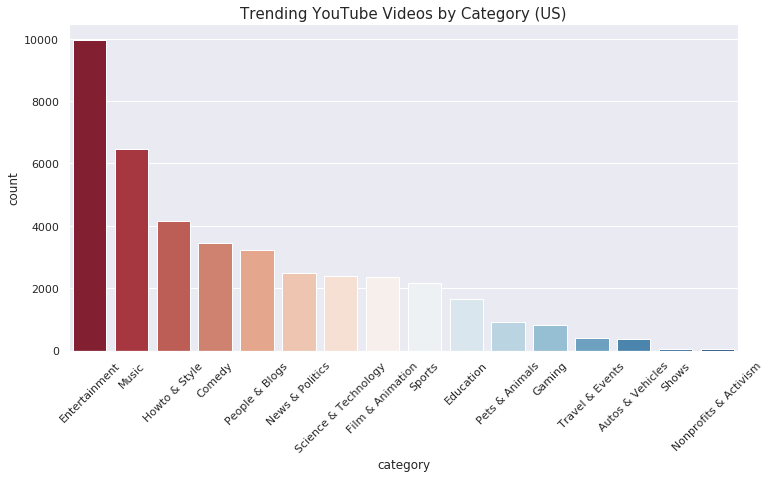

In [0]:
# Visualize the number of trending videos by category
fig, ax = plt.subplots(figsize=(12, 6))

count = sns.countplot(data = us, x = 'category', order = us.category.value_counts().index, palette = 'RdBu')
count.set_xticklabels(count.get_xticklabels(), rotation = 45)
count.set_title('Trending YouTube Videos by Category (US)', fontsize = 15)
plt.show()

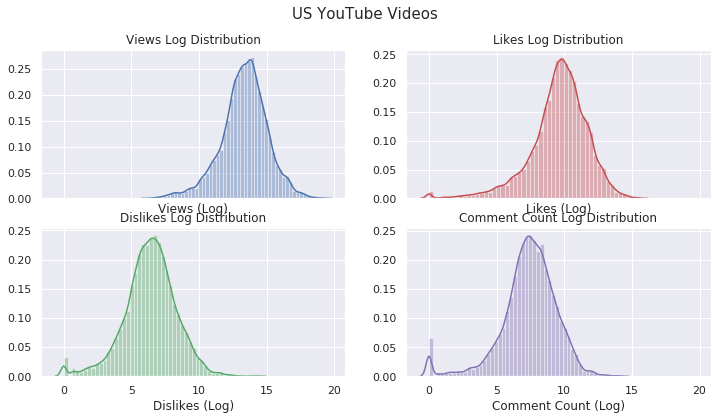

In [0]:
# Distribution plot of views, likes, dislikes, and comment_count
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex = True)

f1 = sns.distplot(np.log(us.views + 1), color='b', ax=axes[0, 0])
f1.set_xlabel('Views (Log)')
f1.set_title('Views Log Distribution')

f2 = sns.distplot(np.log(us.likes + 1), color='r', ax=axes[0, 1])
f2.set_xlabel('Likes (Log)')
f2.set_title('Likes Log Distribution')

f3 = sns.distplot(np.log(us.dislikes + 1), color='g', ax=axes[1, 0])
f3.set_xlabel('Dislikes (Log)')
f3.set_title('Dislikes Log Distribution')

f4 = sns.distplot(np.log(us.comment_count + 1), color='m', ax=axes[1, 1])
f4.set_xlabel('Comment Count (Log)')
f4.set_title('Comment Count Log Distribution')

fig.suptitle('US YouTube Videos', fontsize = 15)
plt.show()

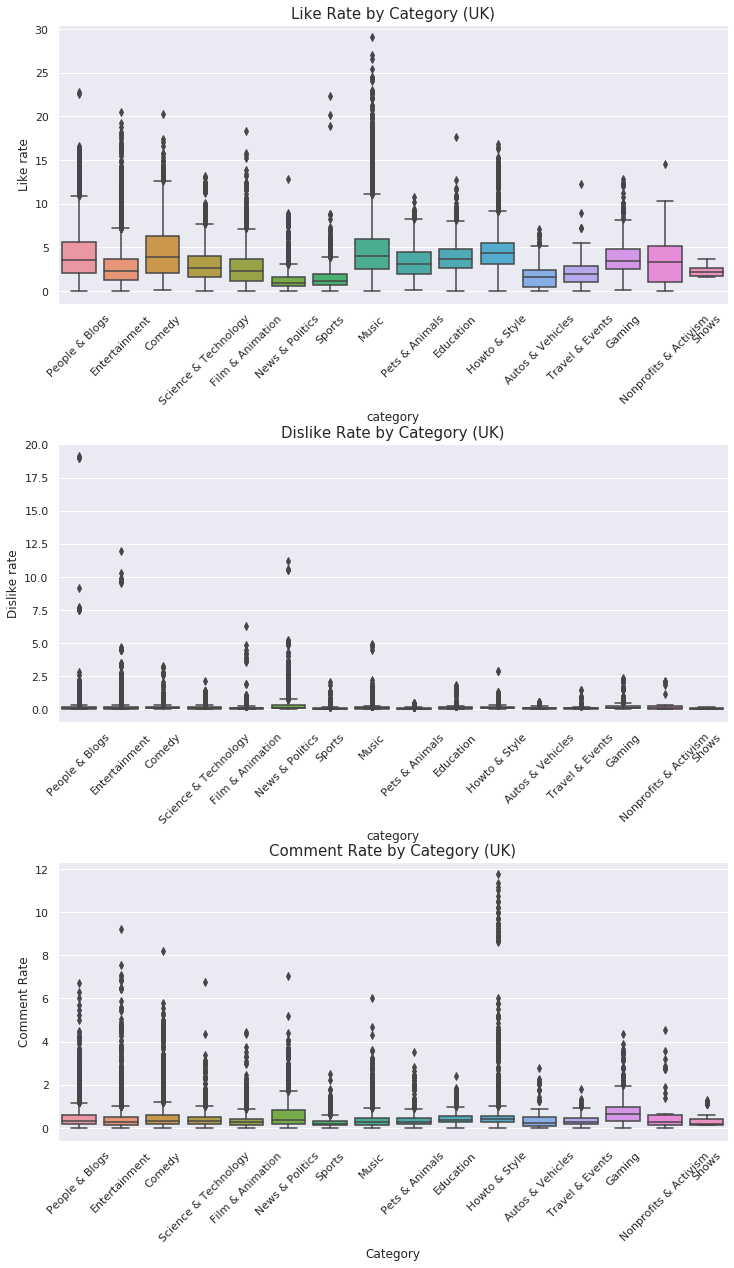

In [0]:
# Create 3 variables that help us understand viewer engagement 
us['like_rate'] =  us['likes'] / us['views'] * 100
us['dislike_rate'] =  us['dislikes'] / us['views'] * 100
us['comment_rate'] =  us['comment_count'] / us['views'] * 100

plt.figure(figsize = (12,20))

plt.subplot(311)
g= sns.boxplot(x='category', y='like_rate', data=us)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Like Rate by Category (US)", fontsize=15)
g2.set_xlabel("Category", fontsize=12)
g.set_ylabel("Like rate", fontsize=12)

plt.subplot(312)
g1= sns.boxplot(x='category', y='dislike_rate', data=us)
g1.set_xticklabels(g.get_xticklabels(),rotation=45)
g1.set_title("Dislike Rate by Category (US)", fontsize=15)
g2.set_xlabel("Category", fontsize=12)
g1.set_ylabel("Dislike rate", fontsize=12)

plt.subplot(313)
g2= sns.boxplot(x='category', y='comment_rate', data=us)
g2.set_xticklabels(g.get_xticklabels(),rotation=45)
g2.set_title("Comment Rate by Category (US)", fontsize=15)
g2.set_xlabel("Category", fontsize=12)
g2.set_ylabel("Comment Rate", fontsize=12)

plt.subplots_adjust(wspace = 0.2, hspace = 0.5,top = 0.9)

plt.show()

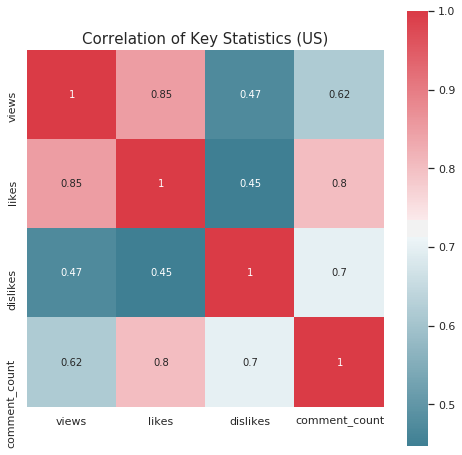

In [0]:
# Correlation heatmap of views, likes, dislikes, and comment count for videos trending in US 
plt.figure(figsize=(8, 8))

corr = us[metric_cols].corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, annot = True)
plt.title("Correlation of Key Statistics (US)", fontsize=15)
plt.show()

Compared to the UK, we see higher correlation between dislikes and views, views and comment count, views and likes. We also see slightly lower correlation between dislikes and comment_count. 

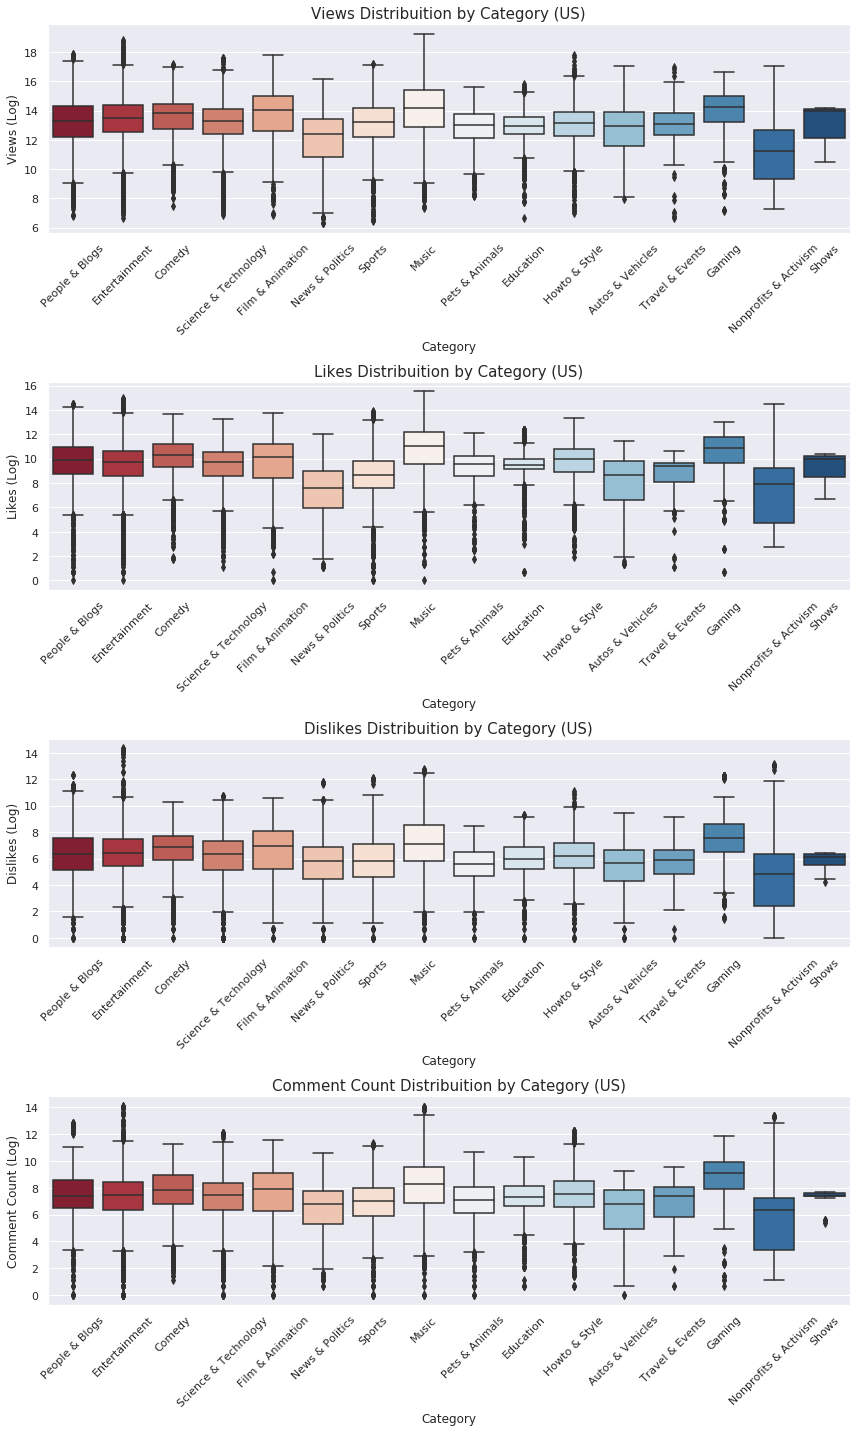

In [0]:
# Boxplot of views, likes, dislikes, and comment_count by category
fig, axes = plt.subplots(4, figsize=(12,20))

views = sns.boxplot(x = 'category', y = np.log(us.views), data = us, palette = 'RdBu', ax = axes[0])
views.set_xticklabels(views.get_xticklabels(), rotation = 45)
views.set_xlabel('Category', fontsize = 12)
views.set_ylabel('Views (Log)', fontsize=12)
views.set_title('Views Distribuition by Category (US)', fontsize = 15)

likes = sns.boxplot(x = 'category', y = np.log(us.likes), data = us, palette = 'RdBu', ax = axes[1])
likes.set_xticklabels(likes.get_xticklabels(), rotation = 45)
likes.set_xlabel('Category', fontsize = 12)
likes.set_ylabel('Likes (Log)', fontsize=12)
likes.set_title('Likes Distribuition by Category (US)', fontsize = 15)

dislikes = sns.boxplot(x = 'category', y = np.log(us.dislikes), data = us, palette = 'RdBu', ax = axes[2])
dislikes.set_xticklabels(dislikes.get_xticklabels(), rotation = 45)
dislikes.set_xlabel('Category', fontsize = 12)
dislikes.set_ylabel('Dislikes (Log)', fontsize=12)
dislikes.set_title('Dislikes Distribuition by Category (US)', fontsize = 15)

comments = sns.boxplot(x = 'category', y = np.log(us.comment_count), data = us, palette = 'RdBu', ax = axes[3])
comments.set_xticklabels(comments.get_xticklabels(), rotation = 45)
comments.set_xlabel('Category', fontsize = 12)
comments.set_ylabel('Comment Count (Log)', fontsize=12)
comments.set_title('Comment Count Distribuition by Category (US)', fontsize = 15)
plt.tight_layout()

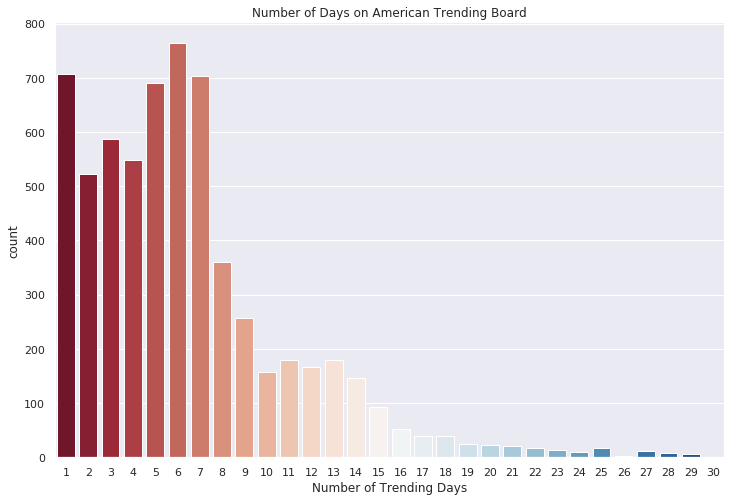

In [0]:
# Visualize the number of trending days per video
trending_days = pd.DataFrame(us.groupby('video_id').size())
trending_days.columns = ['num_trending_days']

plt.figure(figsize = (12, 8))

sns.countplot(trending_days.num_trending_days, palette = 'RdBu')
plt.xlabel('Number of Trending Days')
plt.title('Number of Days on American Trending Board')
plt.show()

The majority of the videos trend for less than a week in the US. The plot suggests that videos trend for a longer duration compared to Canada, but shorter compared to the UK.

Tags

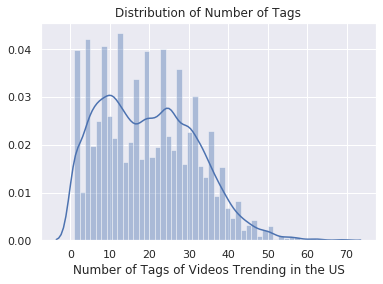

In [0]:
# Distribution plot of the number of tags per video

ustags_per_vid = us.tags.apply(lambda x: len(x.split("|")))
sns.distplot(ustags_per_vid)
plt.xlabel('Number of Tags of Videos Trending in the US')
plt.title('Distribution of Number of Tags')
plt.show()

In [0]:
ustags = " ".join(review for review in us.tags)
print ("There are {} words in the combination of all review.".format(len(ustags)))

There are 11337412 words in the combination of all review.


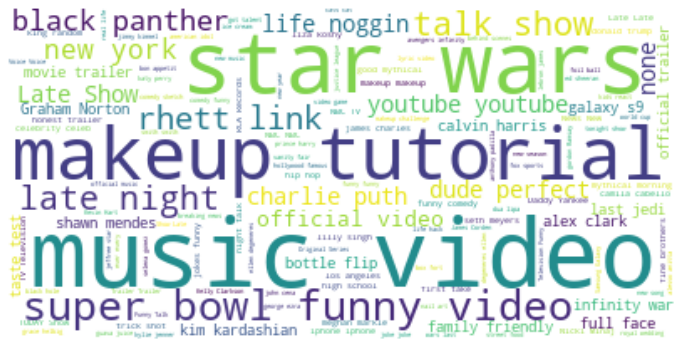

In [0]:
# Generate a word cloud image for tags
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(ustags)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Title

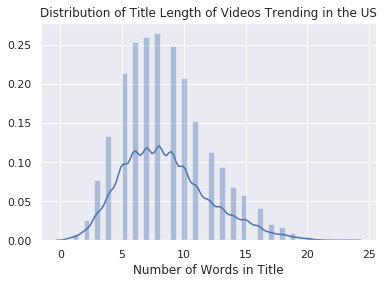

In [0]:
# Distribution plot of title length by word count
ustitle_length = us.title.apply(lambda x: len(x.split()))
sns.distplot(ustitle_length)
plt.xlabel('Number of Words in Title')
plt.title('Distribution of Title Length of Videos Trending in the US')
plt.show()

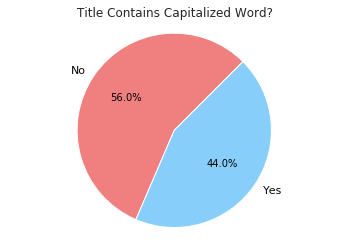

In [0]:
# Visualize the percentage of video titles containing all capitalized words 
us["title_contain_cap"] = us["title"].apply(contains_capitalized_word)

value_counts = us["title_contain_cap"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['lightcoral', 'lightskyblue'], textprops={'color': '#040204'}, autopct='%1.1f%%', startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Title Contains Capitalized Word?')

In [0]:
ustitle = " ".join(review for review in us.title)
print ("There are {} words in the combination of all review.".format(len(ustitle)))

There are 2030176 words in the combination of all review.


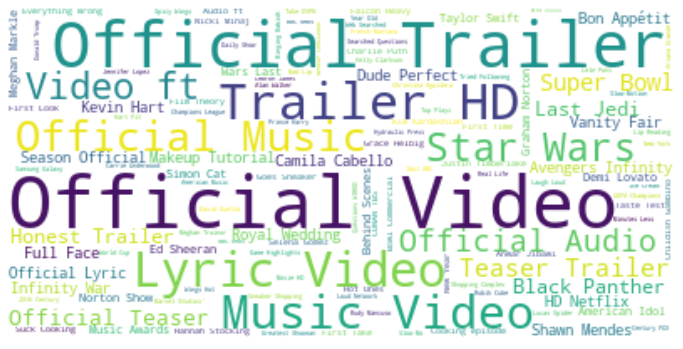

In [0]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(ustitle)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Description

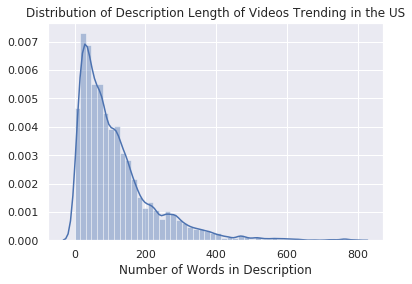

In [0]:
# Distribution plot of description length by wordcount 

usdesc_length = us.description.apply(lambda x: len(x.split()) if type(x) != float else 0)
sns.distplot(usdesc_length) 
plt.xlabel('Number of Words in Description')
plt.title('Distribution of Description Length of Videos Trending in the US')
plt.show()

### Visualizations Across Videos in 3 Countries

In [0]:
# Merge all the dataframes
ca['country'] = 'CA'
gb['country'] = 'UK'
us['country'] = 'US'

df = ca.append(gb)
df = df.append(us)
df.shape

(120746, 22)

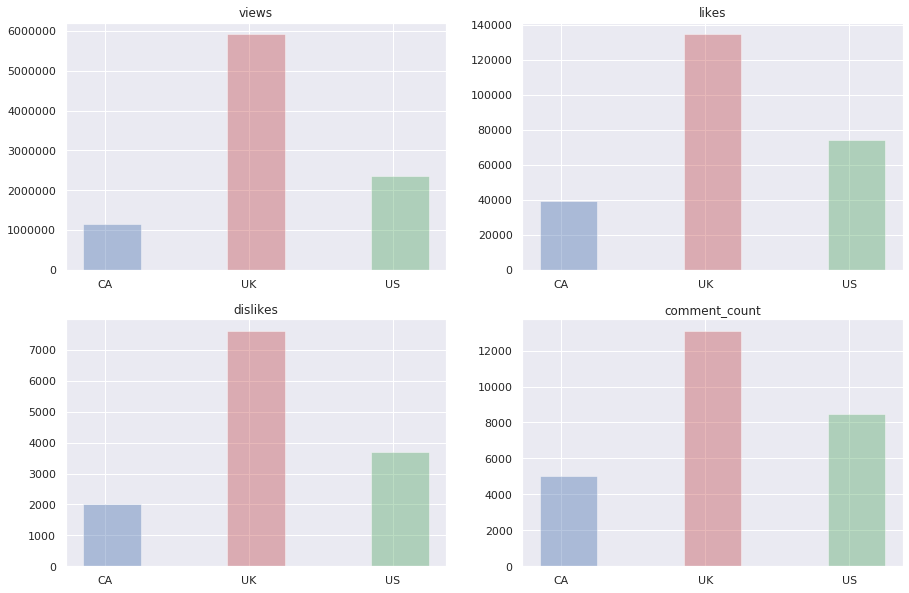

In [0]:
# Comparison of average views, likes, dislikes, comment count in the 3 countries 

to_int = ['views', 'likes', 'dislikes', 'comment_count']
country_list = ['CA','UK','US']

measures = list()
n_groups = len(country_list)
for i, typ in enumerate(to_int):
    measure = []
    for c in country_list:
        measure.append(df[df['country']==c][typ].agg('sum')/len(df[df['country']==c].index.unique()))
    measures.append(measure)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(ncols=2,nrows=2, figsize=(15,10))

index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.4
error_config = {'ecolor': '0.3'}

for i, axs in enumerate([[ax1, ax2], [ax3, ax4]]):
    for j, ax in enumerate(axs):
        ax.bar(index + (bar_width), measures[(i+j)+i], bar_width*4,
                alpha=opacity, color=['b','r','g'],
                error_kw=error_config)
        ax.set_title(to_int[(i+j)+i])
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(country_list)

We can see that the British viewers are most engaged, contributing to the highest count in views, likes, dislikes and comments. In comparison, Canadian viewers are the least engaged. One possible explanayion is videos' trending duration in different countries. Enduring trending videos have the advantages in getting more views, likes, dislikes and comments.

In [0]:
# Create new variable views_cat where 1 marks video as "viral" (top 25% of views) 
top_quart = df.views.describe()['75%']
views_cat = pd.DataFrame(df.views.apply(lambda x: 1 if x > top_quart else 0))
views_cat.columns = ['views_cat']
df = pd.concat([df, views_cat], axis = 1)

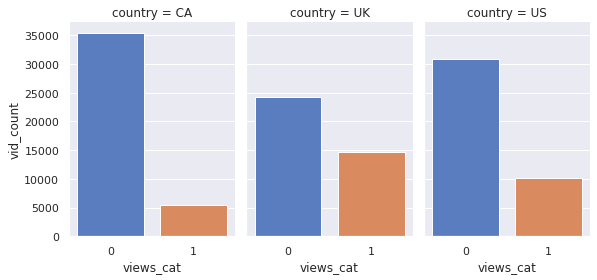

In [0]:
# Visualize the count of viral videos across the 3 countries 
pop = pd.DataFrame(df.groupby(['country','views_cat'])['views_cat'].size().reset_index(name = 'vid_count'))
sns.catplot(x = "views_cat", y = 'vid_count', col = 'country', data = pop, kind = "bar", height = 4, aspect = 0.7, palette='muted' )


UK has the most number of viral videos given their much higher average views per trending video while Canada has the least number of viral videos. This is consistent with our previous finding from comparing key statistics.   

How many YouTube videos trended in more than 1 country?

In [0]:
# Create dataframe of 
ca_video_counts = pd.DataFrame(ca.groupby('title').size(), columns = ['CA'])
gb_video_counts = pd.DataFrame(gb.groupby('title').size(), columns = ['UK'])
us_video_counts = pd.DataFrame(us.groupby('title').size(), columns = ['US'])

video_coexist = ca_video_counts.join(gb_video_counts, how = 'outer')
video_coexist = video_coexist.join(us_video_counts, how = 'outer')
video_coexist = video_coexist.fillna(0)
video_coexist['Total'] = video_coexist.sum(axis = 1)
video_coexist.sort_values(by = 'Total', ascending = False).head()

CA    UK    US  Total
title                                                                     
Sam Smith - Pray (Official Video) ft. Logic         4.0  37.0  29.0   70.0
Childish Gambino - This Is America (Official Vi...  8.0  36.0  25.0   69.0
Maroon 5 - Wait                                     9.0  40.0  18.0   67.0
Getting some air, Atlas?                            3.0  34.0  28.0   65.0
Marvel Studios' Ant-Man and The Wasp - Official...  5.0  36.0  23.0   64.0

In [0]:
total_video = video_coexist.shape[0]
trending_more = ((video_coexist == 0).astype(int).sum(axis=1) > 1).sum()
trending_more_pct = round(((video_coexist == 0).astype(int).sum(axis=1) > 1).sum()/total_video*100, 2)
print('Among {} videos, {} ({}%) videos trended in more than 1 country.'.format(total_video, trending_more, trending_more_pct))

Among 30626 videos, 27367 (89.36%) videos trended in more than 1 country.


Correlation among different countries

It seems like the trending videos from the US and UK have a higher correlation compared to the videos from Canada.

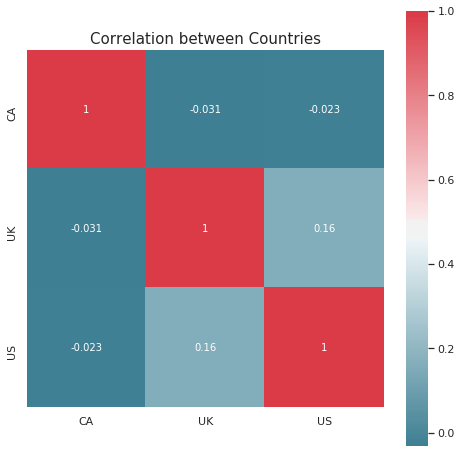

In [0]:
countries = ['CA', 'UK', 'US']
corr_matrix = video_coexist[countries].corr()

plt.figure(figsize = (8, 8))
heatmap = sns.heatmap(corr_matrix,  cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, annot = True)
plt.title('Correlation between Countries', fontsize=15)
plt.show()